In [ ]:
import psycopg2
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


# download precip measurements from the RWIS DB
# store as pandas dataframe

def rwis_connect(name="rwdm", host="rwis.gov.yk.ca", port="5432", username="rwdmread", password="rwdmread"):
    conn = psycopg2.connect(
        dbname=name,
        user=username,
        password=password,
        host=host,
        port=port
    )
    return conn

start_date = datetime(2000, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
end_date = datetime.now(timezone.utc)

important_params = ["pcp1", "pcp6", "pcp12", "pcp24", "rn1"]

important_headers = ["station_id", "measurement_time"]

def get_measurements(conn, columns, start_time, end_time):
    # columns: list of column names to select
    cols = ", ".join(columns)
    query = (
        f"SELECT {cols} FROM measurements_measurement "
        f"WHERE measurement_time > %s AND measurement_time <= %s;"
    )
    with conn.cursor() as cur:
        cur.execute(query, (start_time, end_time))
        rows = cur.fetchall()
        return rows

columns = important_headers + important_params

with rwis_connect() as conn:
    get_measurements = get_measurements(conn, columns, start_date, end_date)

df = pd.DataFrame(get_measurements, columns=columns)

In [3]:
# helper function to extract the first float from a value
# values are stored as tuples [value, flag]
# here we're ignoring the flag, which is almost always -9999

def extract_first_float(val):
    if isinstance(val, list):
        try:
            return float(val[0])
        except Exception:
            return None
    elif val is None:
        return None
    else:
        try:
            return float(val)
        except Exception:
            return None

for col in important_params:
    df[col] = df[col].apply(extract_first_float)

In [ ]:
# create a dataframe for each station
# data is collected at one of four frequencies: 1h, 6h, 12h, 24h
# resample everything to hourly, convert >1hr freqs to hourly, aggregate into single precip column
# store aggregated precip in a dataframe with dims [datetime, station_id]

dfs_hourly = {}
station_ids = df['station_id'].unique()
for sid in station_ids:
    # Isolate data for this station
    df_station = df[df['station_id'] == sid].copy()
    # Ensure measurement_time is a datetime type and set as index
    df_station['measurement_time'] = pd.to_datetime(df_station['measurement_time'], utc=True)
    df_station = df_station.set_index('measurement_time')
    # Resample to regular hourly timestep, preserving all columns
    df_hourly_station = df_station.resample('h').asfreq()
    # Add station_id back as a column for clarity
    df_hourly_station['station_id'] = sid

    for col, window in zip(['pcp6', 'pcp12', 'pcp24'], [6, 12, 24]):
        df_hourly_station[col] = df_hourly_station[col] / window

    # if for some reason there are multiple frequencies for a given timestep, take the average for that timestep
    df_hourly_station["pcp"] = df_hourly_station[["pcp6", "pcp12", "pcp24"]].mean(axis=1)

    # Store in dictionary
    dfs_hourly[sid] = df_hourly_station

    
# Optionally, concatenate all back into a single DataFrame if needed
pcp = pd.concat([x["pcp"] for x in dfs_hourly.values()], axis=1, keys=dfs_hourly.keys())


<Axes: >

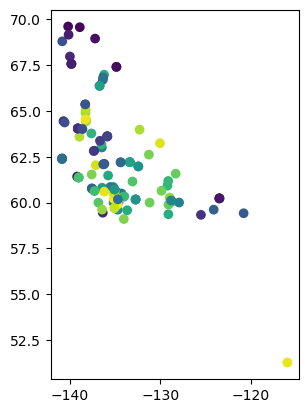

In [49]:
# load station metadata from RWIS DB

def get_stations(conn):
    """Get all stations from stations_stations table"""
    query = "SELECT * FROM stations_station;"
    with conn.cursor() as cur:
        cur.execute(query)
        columns = [desc[0] for desc in cur.description]  # Get column names
        rows = cur.fetchall()
        return rows, columns

# Connect to RWIS and get stations data
with rwis_connect() as conn:
    station_rows, station_columns = get_stations(conn)

# Convert to DataFrame
stations_df = pd.DataFrame(station_rows, columns=station_columns)

# Convert to GeoDataFrame
# Assuming 'longitude' and 'latitude' are the column names for coordinates
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
stations_gdf = gpd.GeoDataFrame(stations_df, geometry=geometry, crs="EPSG:4326")

# Display the first few rows of the GeoDataFrame
stations_gdf[stations_gdf.latitude != -999.0].plot(column='elevation', cmap='viridis')

In [ ]:
# rename station IDs to abbrevs and export to csv

rename_dict = stations_gdf.set_index('id')["abbreviation"].to_dict()

pcp.columns = [int(col) for col in pcp.columns]
pcp.columns = [rename_dict[col] if col in rename_dict.keys() else 'UNMATCHED_STN' for col in pcp.columns]
pcp.to_csv("precip.csv", index=True)


In [66]:
pcp

,NU,SWI,CH,DAF,EPF,PCC,DRU,CYMA-A,CYQH-H,CC,...,THS,JCT37,FFT,NKAK,CBAK,SHAK4,SHAK2,SHAK3,FLR,PLC
measurement_time,,,,,,,,,,,,,,,,,,,,,
2000-03-11 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-11 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-11 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-11 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-12 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-07 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-07 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-07 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


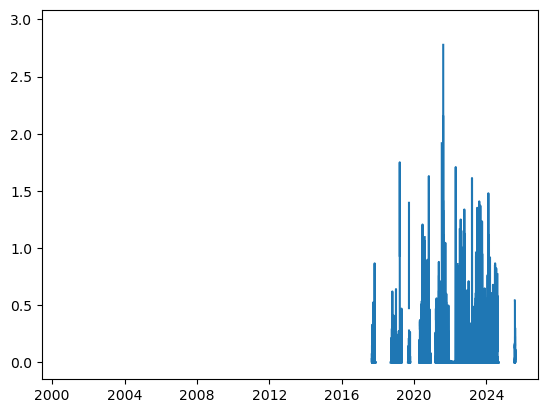

In [67]:
plt.plot(pcp.loc[:,'WNV'])